# Compare Results

Short idea: load metrics from data/results/ and compare the three frameworks (custom AutoML, TPOT, and auto-sklearn) with tables and plots.


## AutoML

Plot RMSE vs iteration for the 4 models from an AutoML `state_matrix.json`. The line is highlighted (thicker) while a model is the one being explored (`current_model=True`).

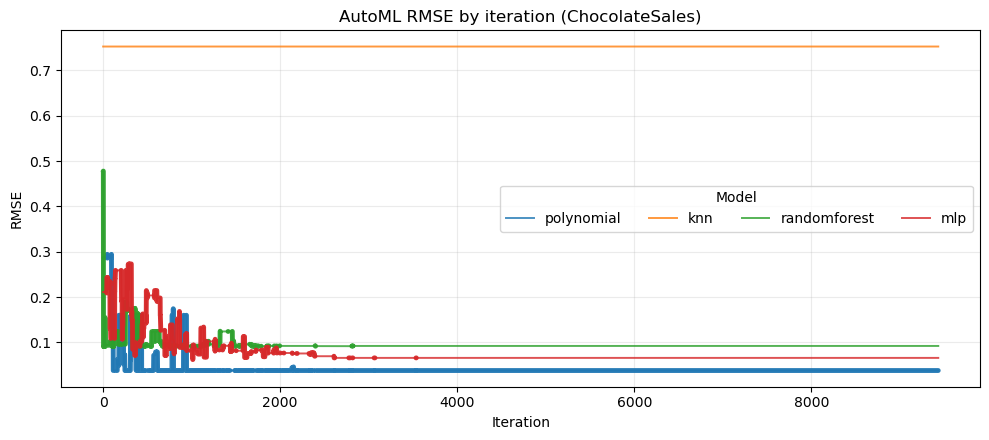

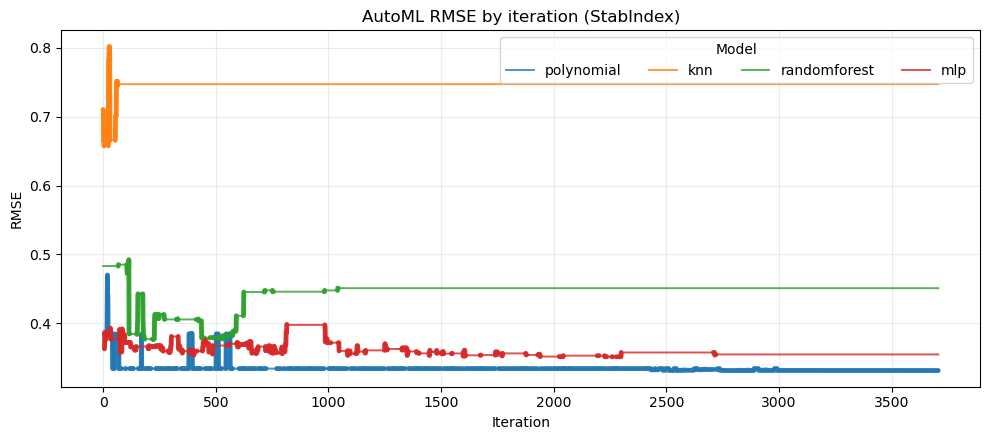

In [5]:
from pathlib import Path
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

cwd = Path.cwd().resolve()
project_root = cwd if (cwd / "data").exists() else cwd.parent

processed_dir = project_root / "data" / "processed"
automl_dir = project_root / "data" / "results" / "automl"

dataset_stems = sorted(p.stem for p in processed_dir.glob("*.csv"))
if not dataset_stems:
    raise FileNotFoundError(f"No datasets found in {processed_dir}")

model_order = ["polynomial", "knn", "randomforest", "mlp"]
colors = {
    "polynomial": "#1f77b4",
    "knn": "#ff7f0e",
    "randomforest": "#2ca02c",
    "mlp": "#d62728",
}

missing_state = []

for dataset_stem in dataset_stems:
    state_matrix_path = automl_dir / f"{dataset_stem}_state_matrix.json"
    if not state_matrix_path.exists():
        missing_state.append(dataset_stem)
        continue

    with state_matrix_path.open("r", encoding="utf-8") as f:
        state_matrix = json.load(f)

    rows = []
    for iter_key, iter_state in state_matrix.items():
        iter_idx = int(iter_key)
        for model_name, model_state in iter_state.items():
            rows.append({
                "iter": iter_idx,
                "model": model_name,
                "rmse": float(model_state["rmse"]),
                "current_model": bool(model_state.get("current_model", False)),
            })

    df = pd.DataFrame(rows).sort_values(["iter", "model"]).reset_index(drop=True)
    local_order = [m for m in model_order if m in df["model"].unique()]

    fig, ax = plt.subplots(figsize=(10, 4.5))

    for model_name in local_order:
        d = df[df["model"] == model_name].sort_values("iter").copy()
        c = colors.get(model_name, None)

        ax.plot(
            d["iter"],
            d["rmse"],
            label=model_name,
            color=c,
            linewidth=1.4,
            alpha=0.8,
        )

        y_highlight = d["rmse"].where(d["current_model"], np.nan)
        ax.plot(
            d["iter"],
            y_highlight,
            color=c,
            linewidth=3.5,
            alpha=0.95,
            solid_capstyle="round",
        )

    ax.set_title(f"AutoML RMSE by iteration ({dataset_stem})")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("RMSE")
    ax.grid(True, alpha=0.25)
    ax.legend(title="Model", ncol=min(4, max(1, len(local_order))))
    plt.tight_layout()
    plt.show()

if missing_state:
    print("Datasets without exact *_state_matrix.json in automl:")
    print(", ".join(missing_state))


## Final Comparison (AutoML, TPOT, auto-sklearn)

Compare final metrics from exact files *_run_summary.json in:
- data/results/automl/ 
- data/results/tpot/ 
- data/results/autosklearn/ 
for each dataset found in data/processed/*.csv.



=== ChocolateSales ===


,dataset,framework,rmse,r2,mae,mse,elapsed_time_s,model
0,ChocolateSales,automl,0.037879,0.998517,0.029393,0.001483,3603.415428,polynomial
1,ChocolateSales,tpot,0.025508,0.999399,0.016753,0.000651,3858.625227,ardregression
2,ChocolateSales,autosklearn,0.025889,0.999301,0.016048,0.000670,3410.399883,ensemble


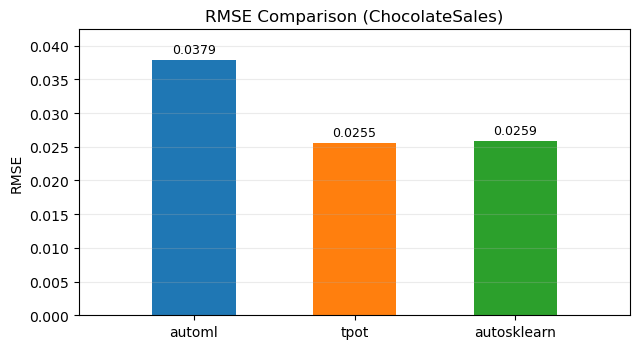

Winner by RMSE: tpot (0.025508)

=== StabIndex ===


,dataset,framework,rmse,r2,mae,mse,elapsed_time_s,model
0,StabIndex,automl,0.331398,0.889653,0.258149,0.109833,3613.165016,polynomial
1,StabIndex,tpot,0.366406,0.872335,0.271776,0.134253,3674.624204,mlpregressor
2,StabIndex,autosklearn,0.330182,0.902376,0.260767,0.109020,3409.253055,ensemble


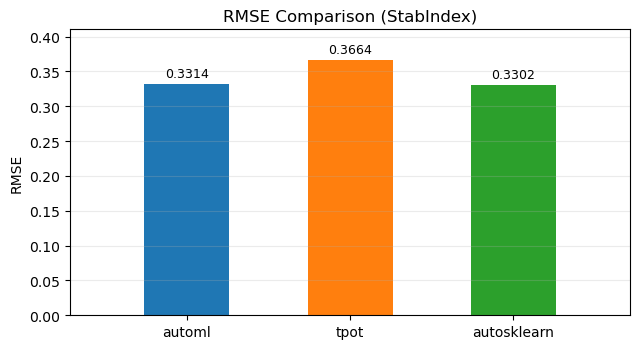

Winner by RMSE: autosklearn (0.330182)

Winner by RMSE per dataset:
       dataset   framework     rmse
ChocolateSales        tpot 0.025508
     StabIndex autosklearn 0.330182


In [6]:
from pathlib import Path
import json
import re

import pandas as pd
import matplotlib.pyplot as plt

cwd = Path.cwd().resolve()
project_root = cwd if (cwd / "data").exists() else cwd.parent

processed_dir = project_root / "data" / "processed"
automl_dir = project_root / "data" / "results" / "automl"
tpot_dir = project_root / "data" / "results" / "tpot"
autoskl_dir = project_root / "data" / "results" / "autosklearn"

dataset_stems = sorted(p.stem for p in processed_dir.glob("*.csv"))
if not dataset_stems:
    raise FileNotFoundError(f"No datasets found in {processed_dir}")

framework_order = ["automl", "tpot", "autosklearn"]
color_map = {
    "automl": "#1f77b4",
    "tpot": "#ff7f0e",
    "autosklearn": "#2ca02c",
}

missing = []
all_rows = []

for dataset_stem in dataset_stems:
    automl_path = automl_dir / f"{dataset_stem}_run_summary.json"
    tpot_path = tpot_dir / f"{dataset_stem}_run_summary.json"
    autoskl_path = autoskl_dir / f"{dataset_stem}_run_summary.json"

    required = {
        "automl": automl_path,
        "tpot": tpot_path,
        "autosklearn": autoskl_path,
    }
    missing_for_dataset = [name for name, p in required.items() if not p.exists()]
    if missing_for_dataset:
        missing.append({"dataset": dataset_stem, "missing": ", ".join(missing_for_dataset)})
        continue

    with automl_path.open("r", encoding="utf-8") as f:
        automl_summary = json.load(f)
    with tpot_path.open("r", encoding="utf-8") as f:
        tpot_summary = json.load(f)
    with autoskl_path.open("r", encoding="utf-8") as f:
        autoskl_summary = json.load(f)

    automl_metrics = dict(automl_summary.get("metrics", {}))
    if "rmse" not in automl_metrics and "rmse" in automl_summary:
        automl_metrics["rmse"] = float(automl_summary["rmse"])
    if "r2" not in automl_metrics and "r2" in automl_summary:
        automl_metrics["r2"] = float(automl_summary["r2"])
    if "mae" not in automl_metrics and "mae" in automl_summary:
        automl_metrics["mae"] = float(automl_summary["mae"])
    if "mse" not in automl_metrics and "mse" in automl_summary:
        automl_metrics["mse"] = float(automl_summary["mse"])

    tpot_metrics = tpot_summary.get("metrics", {})
    autoskl_metrics = autoskl_summary.get("metrics", {})

    tpot_pipeline_file = tpot_dir / f"{dataset_stem}_best_pipeline.txt"
    if not tpot_pipeline_file.exists():
        tpot_pipeline_file = tpot_dir / f"{dataset_stem}_best_pipeline.py"

    best_tpot_model = "unknown"
    if tpot_pipeline_file.exists():
        text = tpot_pipeline_file.read_text(encoding="utf-8", errors="ignore")
        class_hits = re.findall(r"([A-Z][A-Za-z0-9_]*)\s*\(", text)
        wrapper_names = {
            "Pipeline", "FeatureUnion", "StackingEstimator", "EstimatorTransformer",
            "Passthrough", "SkipTransformer", "FunctionTransformer",
        }
        candidates = [c for c in class_hits if c not in wrapper_names]
        if candidates:
            best_tpot_model = candidates[-1].lower()

    dataset_rows = [
        {
            "dataset": dataset_stem,
            "framework": "automl",
            "rmse": float(automl_metrics["rmse"]),
            "r2": automl_metrics.get("r2", None),
            "mae": automl_metrics.get("mae", None),
            "mse": automl_metrics.get("mse", None),
            "elapsed_time_s": float(automl_summary.get("elapsed_time", float("nan"))),
            "model": str(automl_summary.get("best_model", "")),
        },
        {
            "dataset": dataset_stem,
            "framework": "tpot",
            "rmse": float(tpot_metrics["rmse"]),
            "r2": tpot_metrics.get("r2", None),
            "mae": tpot_metrics.get("mae", None),
            "mse": tpot_metrics.get("mse", None),
            "elapsed_time_s": float(tpot_summary.get("elapsed_time", float("nan"))),
            "model": best_tpot_model,
        },
        {
            "dataset": dataset_stem,
            "framework": "autosklearn",
            "rmse": float(autoskl_metrics["rmse"]),
            "r2": autoskl_metrics.get("r2", None),
            "mae": autoskl_metrics.get("mae", None),
            "mse": autoskl_metrics.get("mse", None),
            "elapsed_time_s": float(autoskl_summary.get("elapsed_time", float("nan"))),
            "model": "ensemble",
        },
    ]

    dataset_df = pd.DataFrame(dataset_rows)
    dataset_df["framework"] = pd.Categorical(dataset_df["framework"], categories=framework_order, ordered=True)
    dataset_df = dataset_df.sort_values("framework").reset_index(drop=True)

    print(f"\n=== {dataset_stem} ===")
    display(dataset_df)

    fig, ax = plt.subplots(figsize=(6.5, 3.6))
    bar_colors = [color_map[f] for f in dataset_df["framework"].astype(str)]
    bars = ax.bar(dataset_df["framework"].astype(str), dataset_df["rmse"], color=bar_colors, width=0.52)
    ax.set_title(f"RMSE Comparison ({dataset_stem})")
    ax.set_ylabel("RMSE")
    ax.set_xlabel("")
    ax.margins(x=0.18)
    y_max = float(dataset_df["rmse"].max())
    ax.set_ylim(0, y_max * 1.12 if y_max > 0 else 1.0)
    ax.grid(axis="y", alpha=0.25)
    for b in bars:
        h = b.get_height()
        ax.annotate(f"{h:.4f}", (b.get_x() + b.get_width() / 2, h),
                    ha="center", va="bottom", fontsize=9, xytext=(0, 3), textcoords="offset points")
    plt.tight_layout()
    plt.show()

    winner = dataset_df.loc[dataset_df["rmse"].idxmin()]
    print(f"Winner by RMSE: {winner['framework']} ({winner['rmse']:.6f})")

    all_rows.extend(dataset_rows)

if missing:
    print("\nDatasets skipped (missing exact summary files):")
    print(pd.DataFrame(missing).to_string(index=False))

if all_rows:
    all_df = pd.DataFrame(all_rows)
    winners = all_df.loc[all_df.groupby("dataset")["rmse"].idxmin(), ["dataset", "framework", "rmse"]]
    print("\nWinner by RMSE per dataset:")
    print(winners.to_string(index=False))


